<a href="https://colab.research.google.com/github/Alba251/face_detection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!git clone https://github.com/Alba251/face_detection.git
%cd face_detection


fatal: destination path 'face_detection' already exists and is not an empty directory.
/content/face_detection


In [2]:
#LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tqdm import tqdm


In [6]:
data = pd.read_csv("./data/data.csv", sep=';', dtype={'gender': str})
data.head()

,im_name,gender,left_eye_x,left_eye_y,right_eye_x,right_eye_y,age
0,0.jpg,male,70,111,107,111,37
1,1.jpg,male,71,110,106,111,31
2,2.jpg,male,71,111,106,110,37
3,3.jpg,male,68,111,108,112,51
4,4.jpg,male,71,111,106,110,36


In [ ]:
print(data.describe(include = "all"))

         im_name  gender  left_eye_x  left_eye_y  right_eye_x  right_eye_y  \
count       5000    5000  5000.00000  5000.00000   5000.00000  5000.000000   
unique      5000       2         NaN         NaN          NaN          NaN   
top     4999.jpg  female         NaN         NaN          NaN          NaN   
freq           1    2884         NaN         NaN          NaN          NaN   
mean         NaN     NaN    69.39320   111.18780    107.60540   111.144200   
std          NaN     NaN     1.73931     1.12338      1.70689     1.179866   
min          NaN     NaN    60.00000   104.00000     93.00000   100.000000   
25%          NaN     NaN    68.00000   111.00000    107.00000   111.000000   
50%          NaN     NaN    69.00000   111.00000    108.00000   111.000000   
75%          NaN     NaN    70.00000   112.00000    109.00000   112.000000   
max          NaN     NaN    86.00000   117.00000    114.00000   122.000000   

                age  
count   5000.000000  
unique          NaN

# Preprocessing

In [7]:
#Convert gender column into binary

data['gender'] = data['gender'].map({'male':1, 'female':0})
data.head()


,im_name,gender,left_eye_x,left_eye_y,right_eye_x,right_eye_y,age
0,0.jpg,1,70,111,107,111,37
1,1.jpg,1,71,110,106,111,31
2,2.jpg,1,71,111,106,110,37
3,3.jpg,1,68,111,108,112,51
4,4.jpg,1,71,111,106,110,36


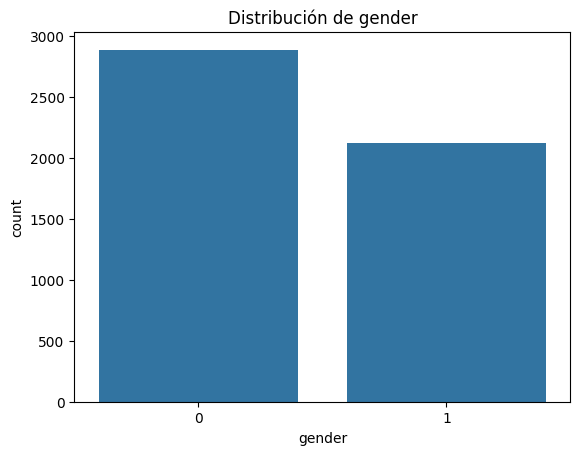

In [ ]:
 #Plot to see the amount of data of each class in gender
sns.countplot(x='gender', data=data)
plt.title("Distribución de gender")
plt.show()

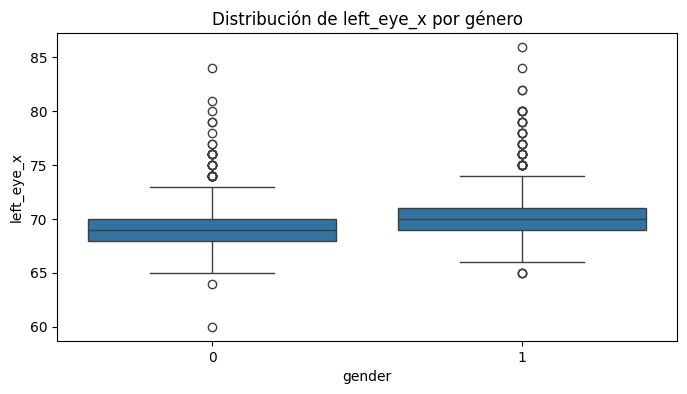

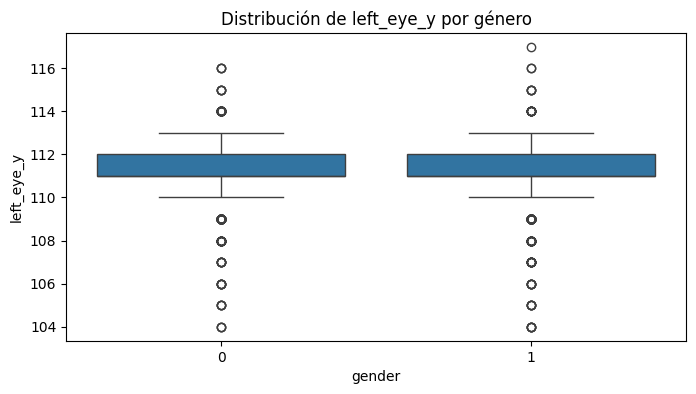

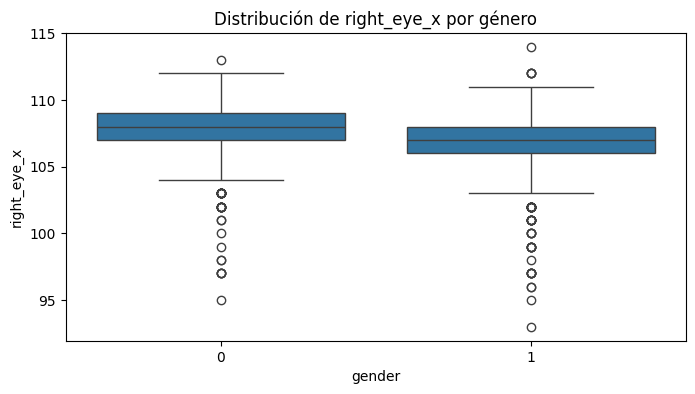

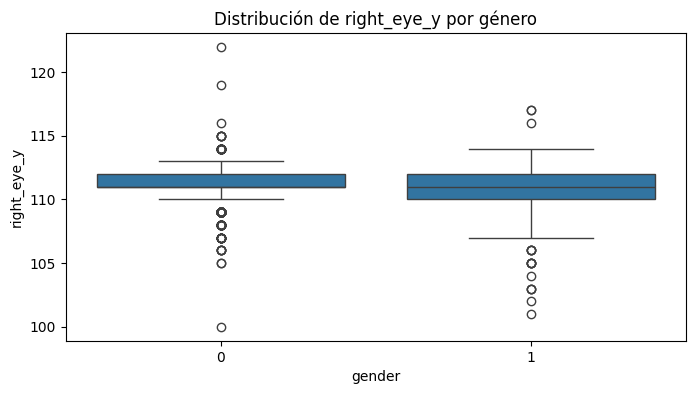

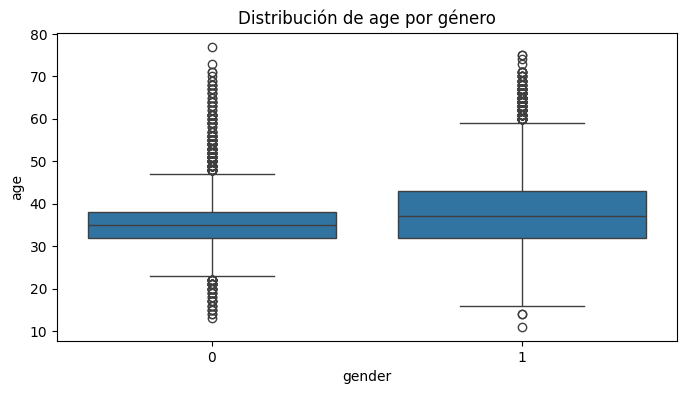

In [ ]:
numerical_cols = ['left_eye_x', 'left_eye_y', 'right_eye_x', 'right_eye_y', 'age']

for col in numerical_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='gender', y=col, data=data)
    plt.title(f'Distribución de {col} por género')
    plt.show()

#Very different results, what has sense as the ages are variable and the eyes can be located anywhere

In [8]:
#Normalization of the age and eye position data, to have all the information in the same range of values and be able to redimensionalize the images

data['left_eye_x'] = data['left_eye_x'] / 178.0
data['right_eye_x'] = data['right_eye_x'] / 178.0
data['left_eye_y'] = data['left_eye_y'] / 218.0
data['right_eye_y'] = data['right_eye_y'] / 218.0
data['age'] = data['age'] / 100.0  # suponiendo que la mayoría no pasa de 100 años, consideramos este valor como máximo posible de edad, dado que un valor mayor generaria un data[age] mayor de 1


data.head()

,im_name,gender,left_eye_x,left_eye_y,right_eye_x,right_eye_y,age
0,0.jpg,1,0.393258,0.509174,0.601124,0.509174,0.37
1,1.jpg,1,0.398876,0.504587,0.595506,0.509174,0.31
2,2.jpg,1,0.398876,0.509174,0.595506,0.504587,0.37
3,3.jpg,1,0.382022,0.509174,0.606742,0.513761,0.51
4,4.jpg,1,0.398876,0.509174,0.595506,0.504587,0.36


In [9]:
#Divide the dataset in train, validate and test

# Step 1:  train + temp (val+test)
images_train, images_temp, genders_train, genders_temp, ages_train, ages_temp, eyes_train, eyes_temp = train_test_split(
    data['im_name'],
    data['gender'],
    data['age'],
    data[['left_eye_x', 'left_eye_y', 'right_eye_x', 'right_eye_y']],
    test_size=0.3,
    stratify=data['gender'],
    random_state=42
)

# Step 2: temp into val and test
images_val, images_test, genders_val, genders_test, ages_val, ages_test, eyes_val, eyes_test = train_test_split(
    images_temp,
    genders_temp,
    ages_temp,
    eyes_temp,
    test_size=0.5,
    stratify=genders_temp,
    random_state=42
)


In [43]:
#Check if the classes is balanced related to gender
print(genders_train.value_counts(normalize=True))
print(genders_val.value_counts(normalize=True))
print(genders_test.value_counts(normalize=True))

gender
0    0.576857
1    0.423143
Name: proportion, dtype: float64
gender
0    0.576
1    0.424
Name: proportion, dtype: float64
gender
0    0.577333
1    0.422667
Name: proportion, dtype: float64


In [10]:
#Resize the input information to a suited structure to be the input of the model

# Load the image
def load_and_preprocess_image(filename):
    img_path = os.path.join("data/images/", filename)
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    return image

# Dataset of TensorFlow (images, labels)
def tf_data_generator(images, genders, ages, eyes, is_train=True):
    for i in range(len(images)):
        if is_train:
            img = load_and_preprocess_image(images.iloc[i])
        else:
            img = load_and_preprocess_image(images.iloc[i])
        gender = genders.iloc[i]
        age = ages.iloc[i]
        eye_pos = eyes.iloc[i].values
        labels = {
            'gender': gender,
            'age': age,
            'eye_pos': eye_pos
        }
        yield img, labels


def create_tf_dataset(images, genders, ages, eyes, is_train=True):
    return tf.data.Dataset.from_generator(
        lambda: tf_data_generator(images, genders, ages, eyes, is_train),
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
            {
                'gender': tf.TensorSpec(shape=(), dtype=tf.float32),
                'age': tf.TensorSpec(shape=(), dtype=tf.float32),
                'eye_pos': tf.TensorSpec(shape=(4,), dtype=tf.float32),
            }
        )
    )

train_dataset = create_tf_dataset(images_train, genders_train, ages_train, eyes_train, is_train=True)
val_dataset = create_tf_dataset(images_val, genders_val, ages_val, eyes_val, is_train=False)
test_dataset = create_tf_dataset(images_test, genders_test, ages_test, eyes_test, is_train=False)

# ADD BATCH AND PREFETCH TO IMPROVE PERFORMANCE
#  Batch: groups images into batches of 32 so that in each iteration the model trains on 32 images at once
#  Prefetch: while the model trains on one batch, it prepares the next batch in parallel

BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



#Check some iterations of the data obtained
for img, label in train_dataset.take(5):
    pass



# Analysis with MobileNetV2

In [45]:
# Specifications of the model

# Input layer
input_img = Input(shape=(224, 224, 3))

# Backbone CNN pretrained with imagenet weights
base_model = MobileNetV2(include_top=False, input_tensor=input_img, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Output 1: Gender (binary)
gender_output = Dense(1, activation='sigmoid', name='gender')(x)

# Output 2: Age (regression)
age_output = Dense(1, name='age')(x)

# Output 3: Eye positions (regression with 4 values)
eye_output = Dense(4, name='eye_pos')(x)

# Final model
model = Model(inputs=input_img, outputs=[gender_output, age_output, eye_output])

model.compile(
    optimizer='adam',
    loss={
        'gender': 'binary_crossentropy',
        'age': 'mse',
        'eye_pos': 'mse'
    },
    metrics={
        'gender': 'accuracy',
        'age': 'mae',
        'eye_pos': 'mae'
    }
)


<ipython-input-45-8f3410bd9a90>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=input_img, weights='imagenet')


In [46]:
#Train the model

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]

steps_per_epoch = len(data['im_name']) // BATCH_SIZE
validation_steps = len(images_val) // BATCH_SIZE

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

test_steps = len(images_test) // BATCH_SIZE

results = model.evaluate(test_dataset, steps=test_steps)
print(results)



Epoch 1/20
110/156 ━━━━━━━━━━━━━━━━━━━━ 15s 347ms/step - age_loss: 0.2457 - age_mae: 0.3243 - eye_pos_loss: 0.1480 - eye_pos_mae: 0.2441 - gender_accuracy: 0.8762 - gender_loss: 0.2982 - loss: 0.6918

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


156/156 ━━━━━━━━━━━━━━━━━━━━ 98s 299ms/step - age_loss: 0.2005 - age_mae: 0.2810 - eye_pos_loss: 0.1190 - eye_pos_mae: 0.2116 - gender_accuracy: 0.8868 - gender_loss: 0.2734 - loss: 0.5927 - val_age_loss: 16.7860 - val_age_mae: 4.0082 - val_eye_pos_loss: 13.2745 - val_eye_pos_mae: 3.5237 - val_gender_accuracy: 0.5380 - val_gender_loss: 3.9392 - val_loss: 33.9998
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 38s 242ms/step - age_loss: 0.0078 - age_mae: 0.0695 - eye_pos_loss: 0.0042 - eye_pos_mae: 0.0512 - gender_accuracy: 0.9670 - gender_loss: 0.0881 - loss: 0.1001 - val_age_loss: 13.9250 - val_age_mae: 3.6581 - val_eye_pos_loss: 12.4953 - val_eye_pos_mae: 3.4199 - val_gender_accuracy: 0.8030 - val_gender_loss: 1.5038 - val_loss: 27.9241
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 25s 163ms/step - age_loss: 0.0061 - age_mae: 0.0605 - eye_pos_loss: 0.0032 - eye_pos_mae: 0.0445 - gender_accuracy: 0.9879 - gender_loss: 0.0324 - loss: 0.0417 - val_age_loss: 6.8995 - val_age_mae: 2.5424 - val_eye_pos_

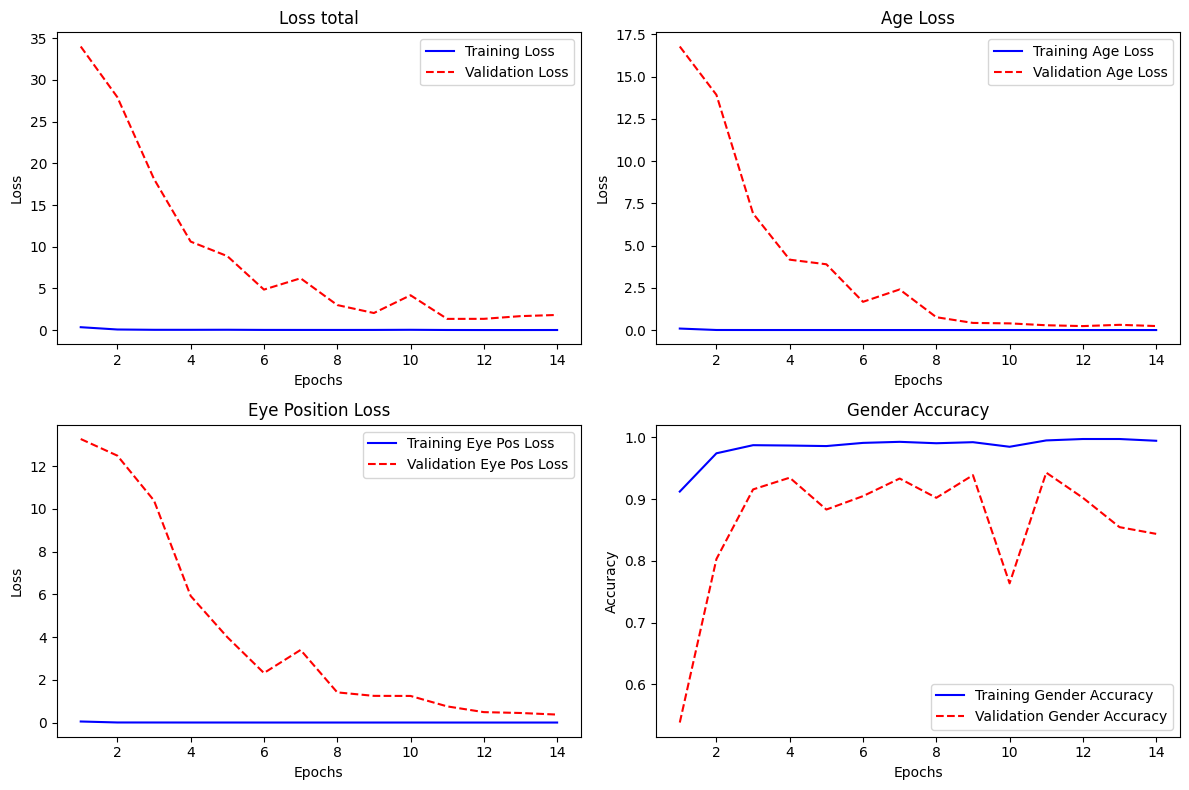

In [48]:
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    # Plot loss total vs val_loss
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r--', label='Validation Loss')
    plt.title('Loss total')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot age_loss vs val_age_loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history.history['age_loss'], 'b-', label='Training Age Loss')
    plt.plot(epochs, history.history['val_age_loss'], 'r--', label='Validation Age Loss')
    plt.title('Age Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot eye_pos_loss vs val_eye_pos_loss
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history.history['eye_pos_loss'], 'b-', label='Training Eye Pos Loss')
    plt.plot(epochs, history.history['val_eye_pos_loss'], 'r--', label='Validation Eye Pos Loss')
    plt.title('Eye Position Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot gender_accuracy vs val_gender_accuracy
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history.history['gender_accuracy'], 'b-', label='Training Gender Accuracy')
    plt.plot(epochs, history.history['val_gender_accuracy'], 'r--', label='Validation Gender Accuracy')
    plt.title('Gender Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Present the graphics of the metrics
plot_training_history(history)

# Analysis with EfficientNetB0

In [49]:

# Backbone CNN preentrenada
base_model = EfficientNetB0(include_top=False, input_tensor=input_img, weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)

# Output 1: Gender (binaria)
gender_output = Dense(1, activation='sigmoid', name='gender')(x)

# Output 2: Age (regresión)
age_output = Dense(1, name='age')(x)

# Output 3: Eye positions (regresión 4 valores)
eye_output = Dense(4, name='eye_pos')(x)

# Modelo final
model = Model(inputs=input_img, outputs=[gender_output, age_output, eye_output])

model.compile(
    optimizer='adam',
    loss={
        'gender': 'binary_crossentropy',
        'age': 'mse',
        'eye_pos': 'mse'
    },
    metrics={
        'gender': 'accuracy',
        'age': 'mae',
        'eye_pos': 'mae'
    }
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]

steps_per_epoch = len(data['im_name']) // BATCH_SIZE
validation_steps = len(images_val) // BATCH_SIZE

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

test_steps = len(images_test) // BATCH_SIZE

results = model.evaluate(test_dataset, steps=test_steps)
print(results)



Epoch 1/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 136s 418ms/step - age_loss: 0.0615 - age_mae: 0.1817 - eye_pos_loss: 0.0550 - eye_pos_mae: 0.1650 - gender_accuracy: 0.8807 - gender_loss: 0.2732 - loss: 0.3895 - val_age_loss: 0.0129 - val_age_mae: 0.0832 - val_eye_pos_loss: 0.0173 - val_eye_pos_mae: 0.0998 - val_gender_accuracy: 0.4239 - val_gender_loss: 0.7464 - val_loss: 0.7766
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 24s 155ms/step - age_loss: 0.0093 - age_mae: 0.0761 - eye_pos_loss: 0.0043 - eye_pos_mae: 0.0515 - gender_accuracy: 0.9708 - gender_loss: 0.0785 - loss: 0.0920 - val_age_loss: 0.0399 - val_age_mae: 0.1804 - val_eye_pos_loss: 0.0219 - val_eye_pos_mae: 0.1354 - val_gender_accuracy: 0.4239 - val_gender_loss: 0.9098 - val_loss: 0.9716
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 24s 155ms/step - age_loss: 0.0097 - age_mae: 0.0764 - eye_pos_loss: 0.0027 - eye_pos_mae: 0.0411 - gender_accuracy: 0.9803 - gender_loss: 0.0559 - loss: 0.0681 - val_age_loss: 0.0076 - val_age_mae: 0.0638 - val_ey

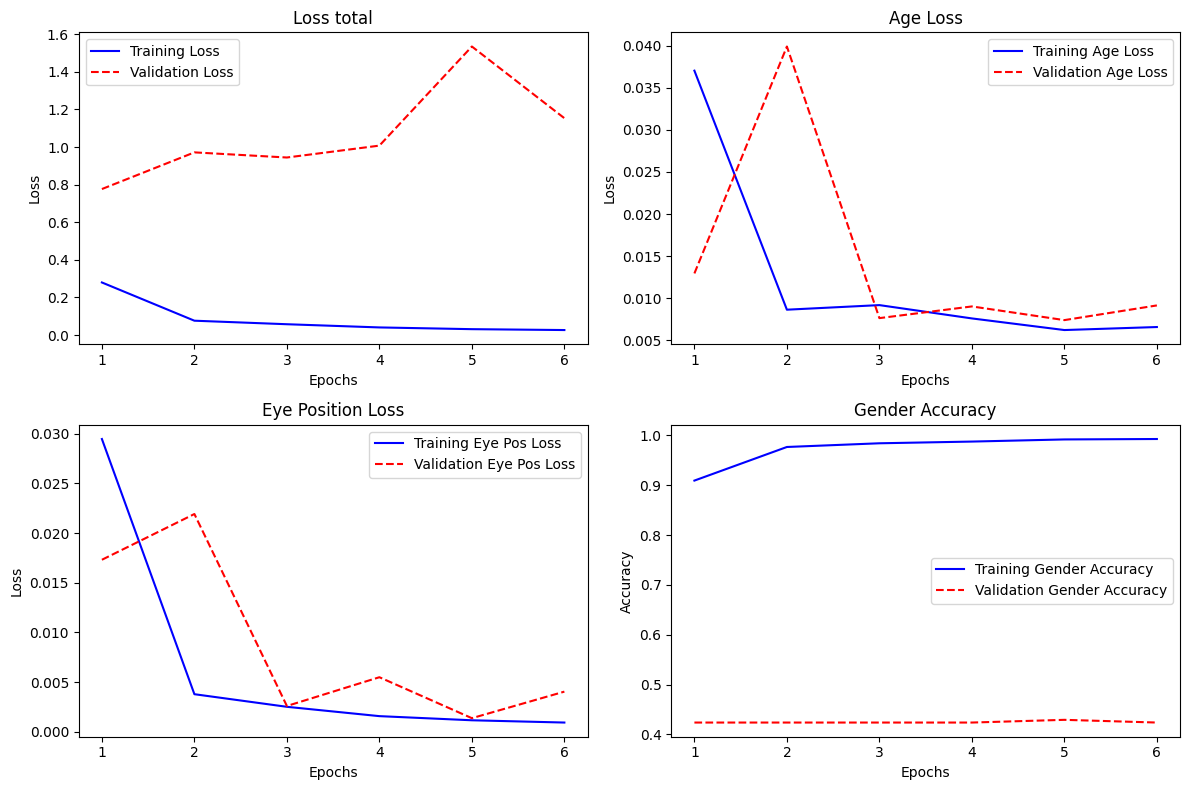

In [50]:
# Present the graphics of the metrics
plot_training_history(history)

# Analysis with ResNet50

In [51]:

# Backbone CNN pretrained
base_model = ResNet50(include_top=False, input_tensor=input_img, weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)

# Output 1: Gender (binary)
gender_output = Dense(1, activation='sigmoid', name='gender')(x)

# Output 2: Age (regression)
age_output = Dense(1, name='age')(x)

# Output 3: Eye positions (regression to 4 values)
eye_output = Dense(4, name='eye_pos')(x)

# Final model
model = Model(inputs=input_img, outputs=[gender_output, age_output, eye_output])

model.compile(
    optimizer='adam',
    loss={
        'gender': 'binary_crossentropy',
        'age': 'mse',
        'eye_pos': 'mse'
    },
    metrics={
        'gender': 'accuracy',
        'age': 'mae',
        'eye_pos': 'mae'
    }
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]

steps_per_epoch = len(data['im_name']) // BATCH_SIZE
validation_steps = len(images_val) // BATCH_SIZE

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

test_steps = len(images_test) // BATCH_SIZE

results = model.evaluate(test_dataset, steps=test_steps)
print(results)


Epoch 1/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 131s 456ms/step - age_loss: 1.7788 - age_mae: 0.3669 - eye_pos_loss: 0.1548 - eye_pos_mae: 0.2105 - gender_accuracy: 0.7055 - gender_loss: 0.5567 - loss: 2.4918 - val_age_loss: 0.0750 - val_age_mae: 0.2600 - val_eye_pos_loss: 0.0828 - val_eye_pos_mae: 0.2694 - val_gender_accuracy: 0.4239 - val_gender_loss: 0.9403 - val_loss: 1.0981
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 48s 305ms/step - age_loss: 0.0109 - age_mae: 0.0812 - eye_pos_loss: 0.0033 - eye_pos_mae: 0.0451 - gender_accuracy: 0.9254 - gender_loss: 0.1787 - loss: 0.1932 - val_age_loss: 0.0749 - val_age_mae: 0.2594 - val_eye_pos_loss: 0.1319 - val_eye_pos_mae: 0.3573 - val_gender_accuracy: 0.4239 - val_gender_loss: 0.7856 - val_loss: 0.9924
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 44s 284ms/step - age_loss: 0.0076 - age_mae: 0.0689 - eye_pos_loss: 0.0025 - eye_pos_mae: 0.0391 - gender_accuracy: 0.9715 - gender_loss: 0.0732 - loss: 0.0834 - val_age_loss: 0.1006 - val_age_mae: 0.3048 - val_ey

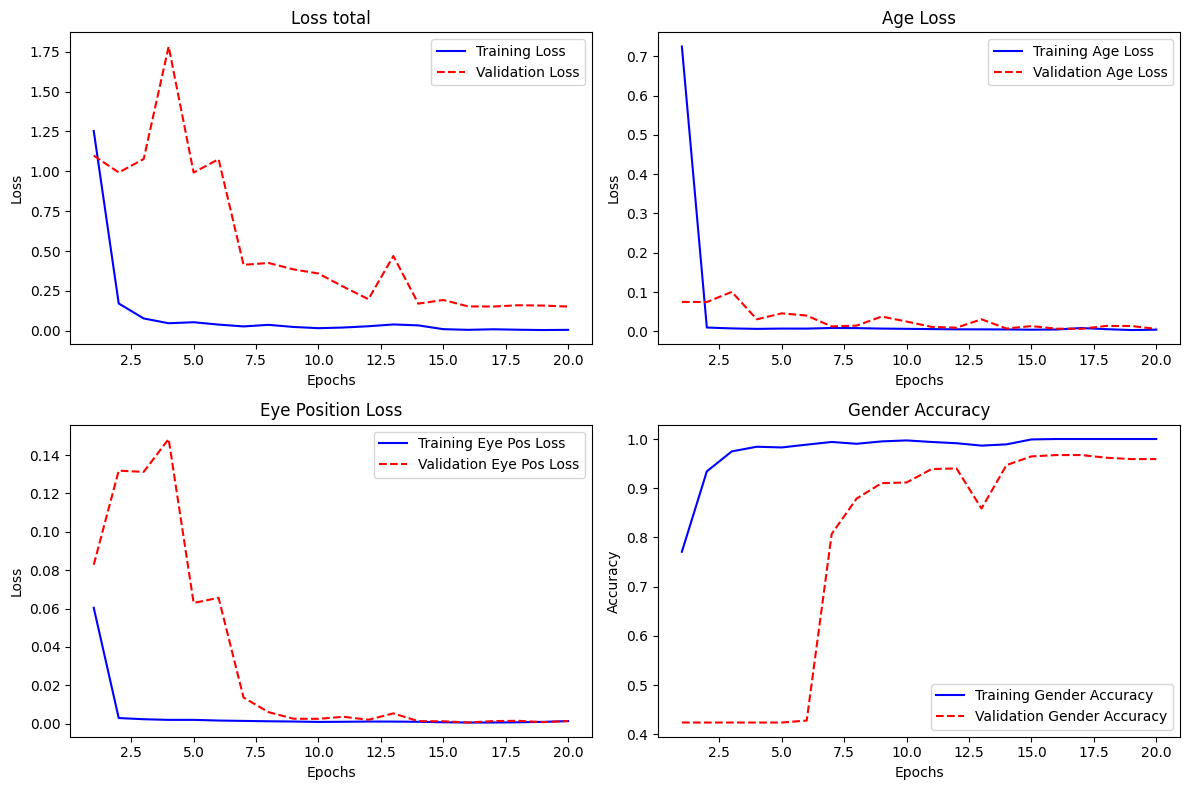

In [52]:
# Presentar grafica de metricas
plot_training_history(history)

# EXTRA CONSIDERING ONLY MOBILENETV2

# Data augmentation
Once selected MobileNetV2, we will analyze the changes by using data augmentation to the training dataset


In [35]:
#Data augmetnation with train dataset
# Bind the training information in a DataFrame
train_data = pd.DataFrame({
    'im_name': images_train,
    'gender': genders_train,
    'age': ages_train,
    'left_eye_x': eyes_train['left_eye_x'].values,
    'left_eye_y': eyes_train['left_eye_y'].values,
    'right_eye_x': eyes_train['right_eye_x'].values,
    'right_eye_y': eyes_train['right_eye_y'].values
})

# Adjust the eye position after flip
def flip_horizontal_and_adjust(image, eyes):
    lx, ly, rx, ry = eyes
    flipped_image = tf.image.flip_left_right(image)
    lx_, rx_ = 1 - rx, 1 - lx
    return flipped_image.numpy(), [lx_, ly, rx_, ry]


# Create a new folder to save the new images (No enough space in RAM of Google Colab)
os.makedirs('data_augmentation/images', exist_ok=True)

# Increase the dataset
labels_list = []
saturation_levels = [0.7, 1.0, 1.3]

for idx, row in tqdm(train_data.iterrows(), total=len(train_data)):
    try:
        image = load_and_preprocess_image(row['im_name'])
        gender = row['gender']
        age = row['age']
        eyes = [row['left_eye_x'], row['left_eye_y'], row['right_eye_x'], row['right_eye_y']]

        for flip in [False, True]:
            img_proc = tf.identity(image)
            eyes_proc = list(eyes)

            if flip:
                img_proc, eyes_proc = flip_horizontal_and_adjust(img_proc, eyes_proc)

            for s in saturation_levels:
                img_aug = tf.image.adjust_saturation(img_proc, s)
                label = [gender, age] + eyes_proc

                name = row['im_name'].split('.')[0]
                flip_tag = "_flip" if flip else ""
                img_name = f"{name}{flip_tag}_sat{s:.1f}.jpg"
                tf.keras.utils.save_img(f"data_augmentation/images/{img_name}", img_aug.numpy())
                labels_list.append([img_name] + label)
    except Exception as e:
        print(f"Error con {row['im_name']}: {e}")

data_augmented = pd.DataFrame(labels_list, columns=['im_name', 'gender', 'age', 'left_eye_x', 'left_eye_y', 'right_eye_x', 'right_eye_y'])


100%|██████████| 3500/3500 [00:45<00:00, 76.38it/s]


In [36]:
#Resize the input information to a suited structure to be the input of the model

#New functions to take the information from the correct folder
def load_and_preprocess_image_train(filename):
    img_path = os.path.join("data_augmentation/images/", filename)
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

# Dataset of TensorFlow (image, labels)
def tf_data_generator(images, genders, ages, eyes, is_train=True):
    for i in range(len(images)):
        if is_train:
            img = load_and_preprocess_image_train(images.iloc[i])
        else:
            img = load_and_preprocess_image(images.iloc[i])
        gender = genders.iloc[i]
        age = ages.iloc[i]
        eye_pos = eyes.iloc[i].values
        labels = {
            'gender': gender,
            'age': age,
            'eye_pos': eye_pos
        }
        yield img, labels


train_dataset = create_tf_dataset(data_augmented['im_name'], data_augmented['gender'], data_augmented['age'], data_augmented[['left_eye_x','left_eye_y', 'right_eye_x','right_eye_y']], is_train=True)
val_dataset = create_tf_dataset(images_val, genders_val, ages_val, eyes_val, is_train=False)
test_dataset = create_tf_dataset(images_test, genders_test, ages_test, eyes_test, is_train=False)

#Batch and prefetch

BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



# Check with an initial dataset
for img, label in train_dataset.take(5):
    pass




In [37]:
# TRAIN THE MODEL
## CHECK THAT THE LAST MODEL DEFINITION IS THE ONE OF MOBILENETV2


callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]

steps_per_epoch = len(data_augmented['im_name']) // BATCH_SIZE
validation_steps = len(images_val) // BATCH_SIZE

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

test_steps = len(images_test) // BATCH_SIZE

results = model.evaluate(test_dataset, steps=test_steps)
print(results)


Epoch 1/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 75s 115ms/step - age_loss: 0.0086 - age_mae: 0.0683 - eye_pos_loss: 0.0015 - eye_pos_mae: 0.0279 - gender_accuracy: 0.9030 - gender_loss: 0.2711 - loss: 0.2832 - val_age_loss: 0.0791 - val_age_mae: 0.2690 - val_eye_pos_loss: 0.0474 - val_eye_pos_mae: 0.2156 - val_gender_accuracy: 0.4239 - val_gender_loss: 4.1062 - val_loss: 4.2580
Epoch 2/20
  1/656 ━━━━━━━━━━━━━━━━━━━━ 4:03:14 22s/step - age_loss: 0.0564 - age_mae: 0.2160 - eye_pos_loss: 0.0018 - eye_pos_mae: 0.0320 - gender_accuracy: 0.6250 - gender_loss: 1.1796 - loss: 1.2495

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


656/656 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - age_loss: 0.0564 - age_mae: 0.2160 - eye_pos_loss: 0.0018 - eye_pos_mae: 0.0320 - gender_accuracy: 0.6250 - gender_loss: 1.1796 - loss: 1.2495 - val_age_loss: 0.0819 - val_age_mae: 0.2740 - val_eye_pos_loss: 0.0474 - val_eye_pos_mae: 0.2154 - val_gender_accuracy: 0.4239 - val_gender_loss: 4.1838 - val_loss: 4.3391
Epoch 3/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 76s 115ms/step - age_loss: 0.0072 - age_mae: 0.0618 - eye_pos_loss: 2.1938e-04 - eye_pos_mae: 0.0114 - gender_accuracy: 0.9732 - gender_loss: 0.0856 - loss: 0.0945 - val_age_loss: 0.0075 - val_age_mae: 0.0615 - val_eye_pos_loss: 0.0188 - val_eye_pos_mae: 0.1349 - val_gender_accuracy: 0.5761 - val_gender_loss: 0.7966 - val_loss: 0.8281
Epoch 4/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - age_loss: 0.0433 - age_mae: 0.1978 - eye_pos_loss: 6.6427e-04 - eye_pos_mae: 0.0214 - gender_accuracy: 1.0000 - gender_loss: 0.0533 - loss: 0.1060 - val_age_loss: 0.0078 - val_age_mae: 0.0661 - val_eye_pos_los

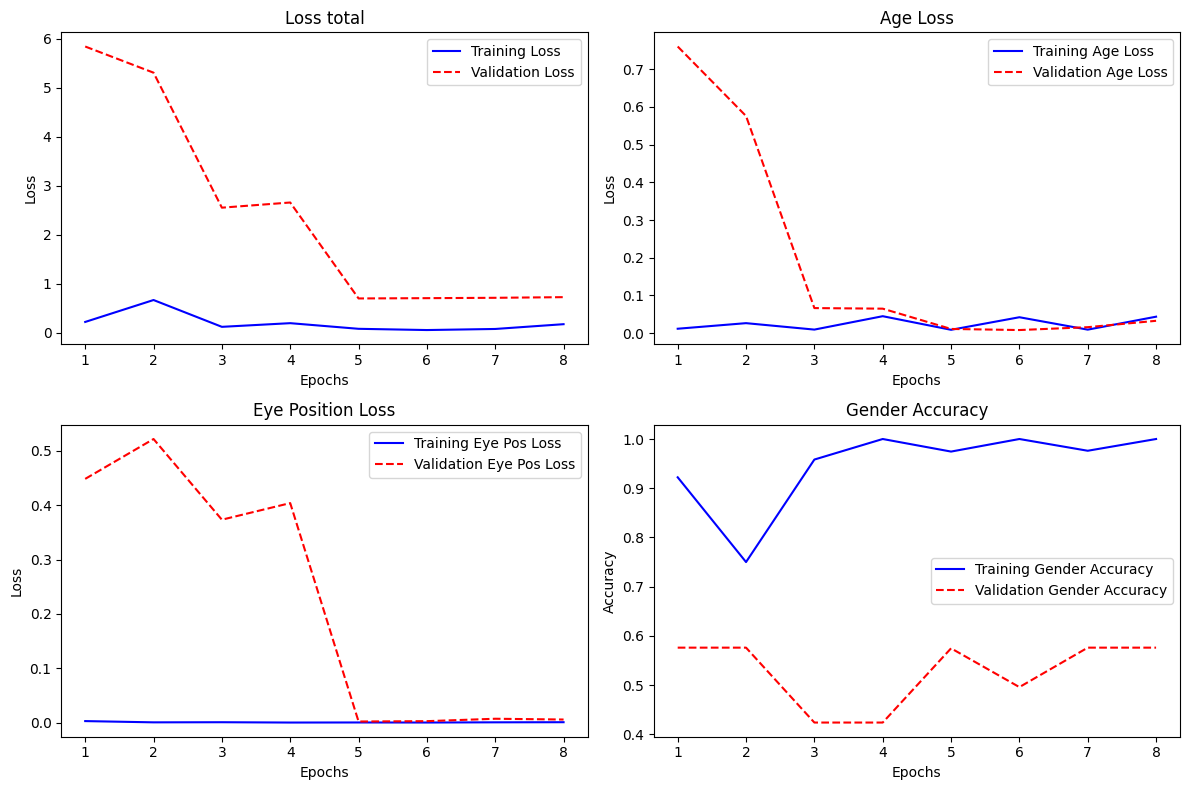

In [ ]:
# Present the graphics of the metrics
plot_training_history(history)


As we can see, eye position and age improve with data augmentation, but gender performance worsens. For this reason, we will assign a higher weight to the gender loss so that the model gives it more importance during training.



In [ ]:
model.compile(
    optimizer='adam',
    loss={
        'gender': 'binary_crossentropy',
        'age': 'mse',
        'eye_pos': 'mse'
    },
    loss_weights={
        'gender': 1.2, ## MORE RELEVANCE TO GENDER VARIABLE
        'age': 1.0,
        'eye_pos': 1.0
    },
    metrics={
        'gender': 'accuracy',
        'age': 'mae',
        'eye_pos': 'mae'
    }
)


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)


results = model.evaluate(test_dataset, steps=test_steps)
print(results)

Epoch 1/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 122s 118ms/step - age_loss: 0.0110 - age_mae: 0.0763 - eye_pos_loss: 0.0020 - eye_pos_mae: 0.0248 - gender_accuracy: 0.9850 - gender_loss: 0.0457 - loss: 0.0679 - val_age_loss: 0.2494 - val_age_mae: 0.4917 - val_eye_pos_loss: 0.5670 - val_eye_pos_mae: 0.7213 - val_gender_accuracy: 0.4239 - val_gender_loss: 1.6923 - val_loss: 2.8472
Epoch 2/20
  1/656 ━━━━━━━━━━━━━━━━━━━━ 3:25:02 19s/step - age_loss: 0.0401 - age_mae: 0.1817 - eye_pos_loss: 5.5700e-04 - eye_pos_mae: 0.0179 - gender_accuracy: 1.0000 - gender_loss: 0.0046 - loss: 0.0462

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


656/656 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - age_loss: 0.0401 - age_mae: 0.1817 - eye_pos_loss: 5.5700e-04 - eye_pos_mae: 0.0179 - gender_accuracy: 1.0000 - gender_loss: 0.0046 - loss: 0.0462 - val_age_loss: 0.2844 - val_age_mae: 0.5261 - val_eye_pos_loss: 0.5625 - val_eye_pos_mae: 0.7194 - val_gender_accuracy: 0.4239 - val_gender_loss: 1.7309 - val_loss: 2.9239
Epoch 3/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 99s 112ms/step - age_loss: 0.0119 - age_mae: 0.0750 - eye_pos_loss: 0.0017 - eye_pos_mae: 0.0199 - gender_accuracy: 0.9823 - gender_loss: 0.0508 - loss: 0.0745 - val_age_loss: 0.5379 - val_age_mae: 0.7281 - val_eye_pos_loss: 0.3235 - val_eye_pos_mae: 0.4059 - val_gender_accuracy: 0.5761 - val_gender_loss: 0.9491 - val_loss: 2.0004
Epoch 4/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - age_loss: 0.0571 - age_mae: 0.2272 - eye_pos_loss: 0.0011 - eye_pos_mae: 0.0298 - gender_accuracy: 1.0000 - gender_loss: 0.0186 - loss: 0.0805 - val_age_loss: 0.5842 - val_age_mae: 0.7592 - val_eye_pos_loss: 0

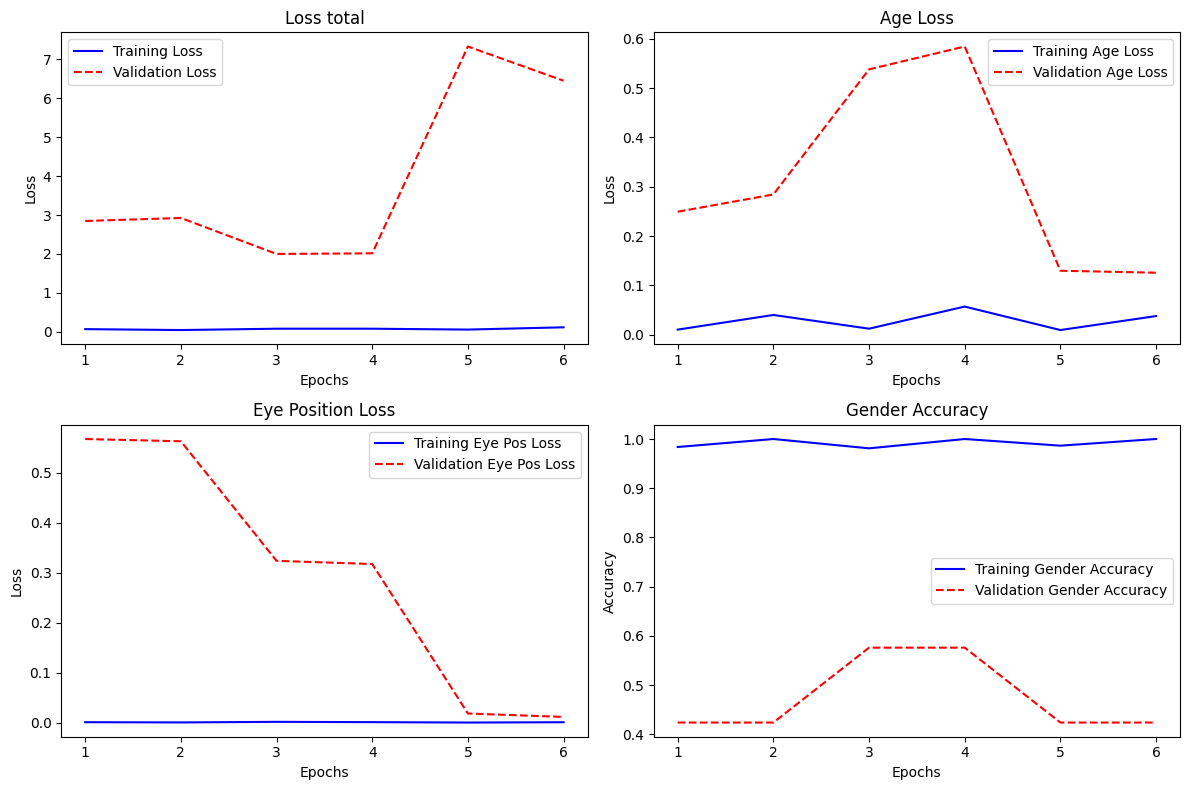

In [ ]:
# Present the graphics of the metrics
plot_training_history(history)

Result: the situation has worsened, causing overfitting, since the model performs well during training, but the validation results are even worse.
We are going to try adding an extra dense head to the gender output so that it has a small submodel and becomes more specialized in this variable.

In [23]:
# SPECIFICATIONS OF THE MODEL

# Input layer
input_img = Input(shape=(224, 224, 3))

# Backbone CNN preentrenada
base_model = MobileNetV2(include_top=False, input_tensor=input_img, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Output 1: Gender (binary)
g = Dense(64, activation='relu')(x) ## EXTRA LAYER
gender_output = Dense(1, activation='sigmoid', name='gender')(g)

# Output 2: Age (regression)
age_output = Dense(1, name='age')(x)

# Output 3: Eye positions (regression 4 values)
eye_output = Dense(4, name='eye_pos')(x)

# Final model
model = Model(inputs=input_img, outputs=[gender_output, age_output, eye_output])

model.compile(
    optimizer='adam',
    loss={
        'gender': 'binary_crossentropy',
        'age': 'mse',
        'eye_pos': 'mse'
    },
    loss_weights={
        'gender': 1.0,
        'age': 1.0,
        'eye_pos': 1.0
    },
    metrics={
        'gender': 'accuracy',
        'age': 'mae',
        'eye_pos': 'mae'
    }
)


<ipython-input-23-76b30205f57e>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=input_img, weights='imagenet')


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)


results = model.evaluate(test_dataset, steps=test_steps)
print(results)

Epoch 1/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 123s 118ms/step - age_loss: 0.1035 - age_mae: 0.1611 - eye_pos_loss: 0.0397 - eye_pos_mae: 0.1140 - gender_accuracy: 0.8316 - gender_loss: 0.3791 - loss: 0.5224 - val_age_loss: 0.0851 - val_age_mae: 0.2796 - val_eye_pos_loss: 1.2965 - val_eye_pos_mae: 1.0984 - val_gender_accuracy: 0.4239 - val_gender_loss: 1.0124 - val_loss: 2.3941
Epoch 2/20
  1/656 ━━━━━━━━━━━━━━━━━━━━ 3:18:09 18s/step - age_loss: 0.0392 - age_mae: 0.1935 - eye_pos_loss: 0.0066 - eye_pos_mae: 0.0685 - gender_accuracy: 0.7500 - gender_loss: 1.8032 - loss: 1.8491

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


656/656 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - age_loss: 0.0392 - age_mae: 0.1935 - eye_pos_loss: 0.0066 - eye_pos_mae: 0.0685 - gender_accuracy: 0.7500 - gender_loss: 1.8032 - loss: 1.8491 - val_age_loss: 0.1299 - val_age_mae: 0.3500 - val_eye_pos_loss: 1.2796 - val_eye_pos_mae: 1.0896 - val_gender_accuracy: 0.4239 - val_gender_loss: 1.0730 - val_loss: 2.4825
Epoch 3/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 82s 125ms/step - age_loss: 0.0091 - age_mae: 0.0725 - eye_pos_loss: 0.0024 - eye_pos_mae: 0.0377 - gender_accuracy: 0.9323 - gender_loss: 0.1815 - loss: 0.1931 - val_age_loss: 0.4981 - val_age_mae: 0.7005 - val_eye_pos_loss: 0.4293 - val_eye_pos_mae: 0.6508 - val_gender_accuracy: 0.5747 - val_gender_loss: 0.7090 - val_loss: 1.6364
Epoch 4/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - age_loss: 0.0191 - age_mae: 0.1352 - eye_pos_loss: 0.0048 - eye_pos_mae: 0.0593 - gender_accuracy: 0.6250 - gender_loss: 0.6742 - loss: 0.6981 - val_age_loss: 0.5040 - val_age_mae: 0.7046 - val_eye_pos_loss: 0.443

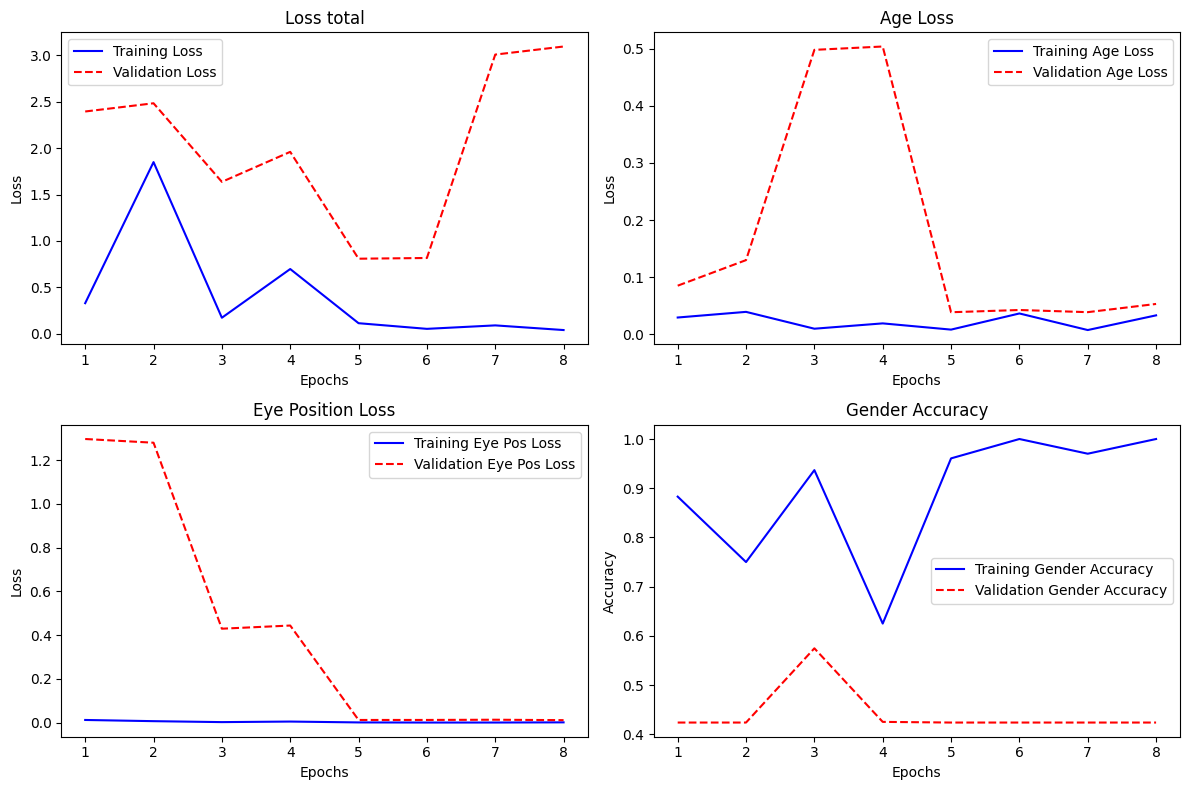

In [ ]:
# Present the graphics of the metrics
plot_training_history(history)

# Changes in structure without data augmentation
Since the results with data augmentation have not improved, we are going to test the architectural changes on the database without applying data augmentation.


*   Extra layer in the output heads, to icnrease the specificity with the concrete variable
*   Increase weights of eye position and age




In [11]:
train_dataset = create_tf_dataset(images_train, genders_train, ages_train, eyes_train, is_train=True)
val_dataset = create_tf_dataset(images_val, genders_val, ages_val, eyes_val, is_train=False)
test_dataset = create_tf_dataset(images_test, genders_test, ages_test, eyes_test, is_train=False)

#Batch and prefetch

BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [12]:
# Model Specifications

# Input layer
input_img = Input(shape=(224, 224, 3))

# Backbone CNN preentrenada
base_model = MobileNetV2(include_top=False, input_tensor=input_img, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Output 1: Gender (binary)
g = Dense(64, activation='relu')(x) ## EXTRA LAYER
gender_output = Dense(1, activation='sigmoid', name='gender')(g)

# Output 2: Age (regression)
a = Dense(64, activation='relu')(x) ## EXTRA LAYER
age_output = Dense(1, name='age')(a)

# Output 3: Eye positions (regression of 4 values)
e = Dense(64, activation='relu')(x) ## EXTRA LAYER
eye_output = Dense(4, name='eye_pos')(e)

# Final model
model = Model(inputs=input_img, outputs=[gender_output, age_output, eye_output])

model.compile(
    optimizer='adam',
    loss={
        'gender': 'binary_crossentropy',
        'age': 'mse',
        'eye_pos': 'mse'
    },
    loss_weights={
        'gender': 1.0,
        'age': 1.2,
        'eye_pos': 1.5
    },
    metrics={
        'gender': 'accuracy',
        'age': 'mae',
        'eye_pos': 'mae'
    }
)

<ipython-input-12-84c6f4bae016>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=input_img, weights='imagenet')


In [13]:
#Train the model

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]

steps_per_epoch = len(data['im_name']) // BATCH_SIZE
validation_steps = len(images_val) // BATCH_SIZE

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

test_steps = len(images_test) // BATCH_SIZE

results = model.evaluate(test_dataset, steps=test_steps)
print(results)

Epoch 1/20
110/156 ━━━━━━━━━━━━━━━━━━━━ 17s 371ms/step - age_loss: 0.1356 - age_mae: 0.1986 - eye_pos_loss: 0.1196 - eye_pos_mae: 0.1829 - gender_accuracy: 0.8486 - gender_loss: 0.3099 - loss: 0.6521

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


156/156 ━━━━━━━━━━━━━━━━━━━━ 103s 308ms/step - age_loss: 0.1071 - age_mae: 0.1706 - eye_pos_loss: 0.0937 - eye_pos_mae: 0.1555 - gender_accuracy: 0.8656 - gender_loss: 0.2809 - loss: 0.5500 - val_age_loss: 0.1274 - val_age_mae: 0.2995 - val_eye_pos_loss: 9.9997 - val_eye_pos_mae: 2.6859 - val_gender_accuracy: 0.7527 - val_gender_loss: 2.6228 - val_loss: 17.7752
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - age_loss: 0.0066 - age_mae: 0.0611 - eye_pos_loss: 0.0027 - eye_pos_mae: 0.0400 - gender_accuracy: 0.9523 - gender_loss: 0.1155 - loss: 0.1274 - val_age_loss: 0.3591 - val_age_mae: 0.5169 - val_eye_pos_loss: 7.8620 - val_eye_pos_mae: 2.4353 - val_gender_accuracy: 0.8207 - val_gender_loss: 2.0546 - val_loss: 14.2785
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 42s 266ms/step - age_loss: 0.0058 - age_mae: 0.0571 - eye_pos_loss: 0.0014 - eye_pos_mae: 0.0288 - gender_accuracy: 0.9766 - gender_loss: 0.0581 - loss: 0.0672 - val_age_loss: 0.2483 - val_age_mae: 0.4765 - val_eye_pos_los

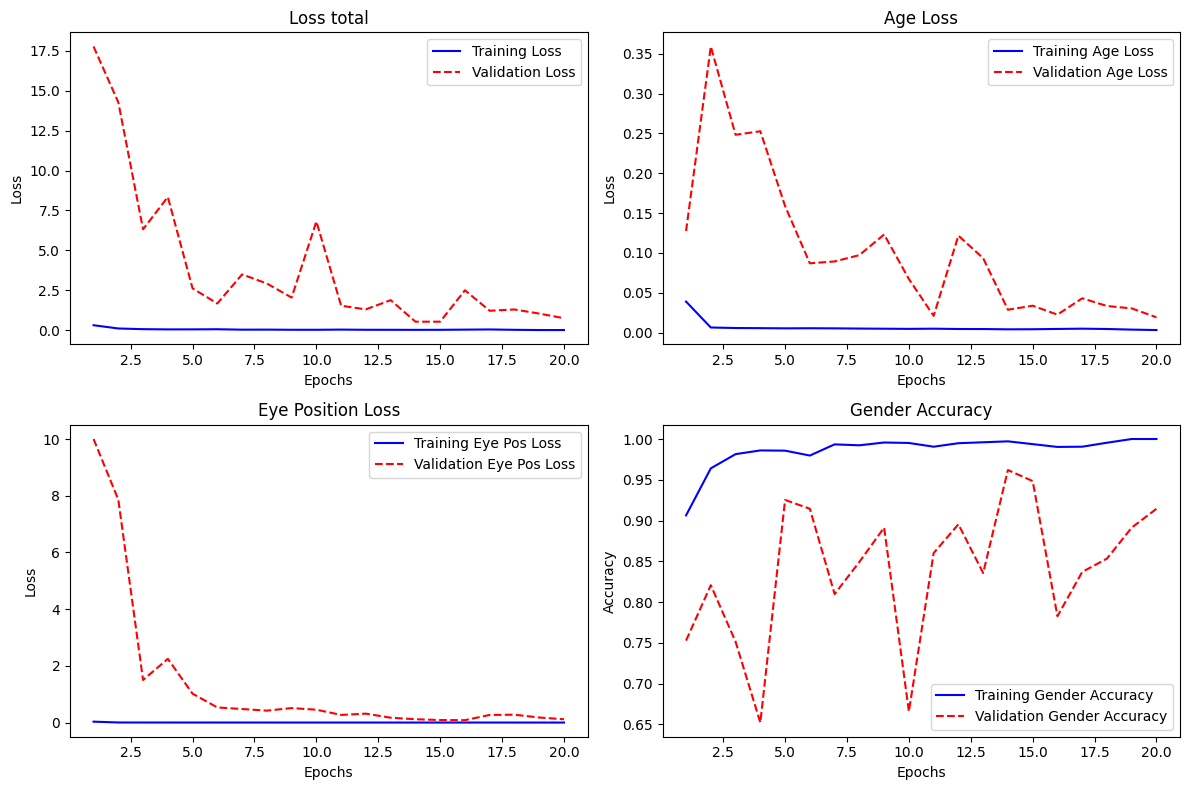

In [16]:
# Present the graphics of the metrics


plot_training_history(history)